# Getting Started with Selene

This tutorial explores the core components of Selene, and should teach you everything you need to know to train a simple model on biological sequence data. 
Before starting this tutorial, you need to install Selene.
Instructions for installation are available [here](https://selene.flatironinstitute.org/overview/installation.html).
Lastly, if you are not familiar with neural networks, we recommend reading through this [introductory PyTorch tutorial on neural networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).
In the simplest case, we train a neural network as follows:

1. Construct our neural network, which should be a [`torch.nn.Module`](https://pytorch.org/docs/stable/nn .html#torch.nn.Module) object
2. Load the training data and divide it into training and validation sets
3. Iterate over the training set
4. Compute and backpropagate the training loss after each iteration
5. Save the model weights at specified intervals
6. Compute and report the loss on the validation set at specified intervals
7. Compute and report the loss on the validation set after training is complete

In this case, much of our work is already done for us.
In fact, we do not actually need to write any code besides our model and a configuration file.

## Dependencies

In addition to the `selene-sdk` library, we also use [`htslib`](https://www.htslib.org) for data processing. Specifically, we use the tools [**`tabix`**](https://www.htslib.org/doc/tabix.html) and [**`bgzip`**](https://www.htslib.org/doc/bgzip.html) from `htslib`. 

If you eventually want to use Selene on new data, please download `htslib`. We recommend using `selene-sdk` in a [conda environment](https://conda.io/docs/user-guide/tasks/manage-environments.html) and installing `htslib` (`conda install htslib -c bioconda`) to that same environment. 

However, if you take this approach, you can only use `tabix` and `bgzip` on the command-line when the conda environment is activated. You can instead download and build the package on your machine by following the instructions on the [`htslib` website](http://www.htslib.org/download/). 

## Download and format the data

First, we need to download the data. (The "Shortcut" below contains all the formatted data in a `.tar.gz`.)

In this tutorial, we will go through a single-feature example with [data](http://hgdownload.cse.ucsc.edu/goldenpath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/) from the ENCODE Uniform TFBS composite track. These are the transcription factor datasets that were used to train [Zhou and Troyanskaya's (2015)](https://doi.org/10.1038/nmeth.3547) DeepSEA model.

We can download the measurements for transcription factor CTCF in cell type GM12878 by running

```sh
wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/wgEncodeAwgTfbsUtaGm12878CtcfUniPk.narrowPeak.gz
```

and format the data with

```sh
bgzip -d wgEncodeAwgTfbsUtaGm12878CtcfUniPk.narrowPeak.gz

cut -f 1-3 wgEncodeAwgTfbsUtaGm12878CtcfUniPk.narrowPeak > GM12878_CTCF.bed

sed -i "s/$/\tGM12878|CTCF|None/" GM12878_CTCF.bed

sort -k1V -k2n -k3n GM12878_CTCF.bed > sorted_GM12878_CTCF.bed
```

The formatted BED file should contain 4 columns, in order: chromosome, start, end, feature. We do not support strand-specific data at this time (it will be added in a later version of Selene).

In this example, we will use the `IntervalsSampler` class for partitioning and sampling the data. The intervals sampler requires that we pass in an intervals file with 3 columns: chrom, start, end. This intervals file determines where in the genome we sample our data. We have provided an intervals file for you (`deepsea_TF_intervals.txt`) with the regions in the original DeepSEA dataset that contained at least 1 transcription factor (TF). This is included in the Zenodo record below--we do not store it in the repository. We will refer to this file as "DeepSEA TF regions" from now on.

It also requires that we tabix-index the dataset BED file for fast querying of targets in genomic regions.

```sh
bgzip -c sorted_GM12878_CTCF.bed > sorted_GM12878_CTCF.bed.gz

tabix -p bed sorted_GM12878_CTCF.bed.gz
```

Selene provides sampler classes to partition your dataset into training/testing/validation sets and will draw examples from the appropriate partitions during the training/evaluation process.

These sampler classes require that you have a file containing the distinct genomic features that the model predicts. Note that when we refer to a model's "features", we are referring to the genomic features that it predicts (i.e. they are the same as classes, labels, or targets that a deep learning model predicts). 

```sh
cut -f 4 sorted_GM12878_CTCF.bed | sort -u > distinct_features.txt
```

Finally, we must download the hg19 FASTA file:

```sh
wget https://www.encodeproject.org/files/male.hg19/@@download/male.hg19.fasta.gz

bgzip -d male.hg19.fasta.gz
```

### SHORTCUT: download all formatted data from Zenodo record

Download the compressed data from here:

```sh
wget https://zenodo.org/record/1443558/files/selene_quickstart.tar.gz
```

Extract it and `mv` all files from the extracted directory `selene_quickstart_tutorial` to the current directory:

```sh
tar -xzvf selene_quickstart.tar.gz
mv selene_quickstart_tutorial/* .
```

## Command line arguments

At the end of this tutorial, we run Selene using library functions. These are the same functions used in Selene's [command-line interface (CLI)](https://github.com/FunctionLab/selene/blob/master/selene_cli.py), a file that users can copy and use after installing Selene or cloning and building the local version. 

If you use the CLI script, please install `docopt` (`conda install docopt`), which the CLI relies on to parse input arguments.

Selene uses a limited number (two to be precise) of command line arguments.
The first of these is the positional parameter for the configuration file, which we will discuss in more detail in the following section.
The second argument is the optional named argument for the learning rate, specified with `--lr`.
The learning rate only needs to be specified when Selene is training a model, and is ignored in all other circumstances.

If you install Selene via conda or pip (we recommend conda), only download and use the CLI script--there is no need to clone the entire repository. You should only do so if you plan on developing or modifying Selene yourself.

## Configuration file syntax

The configuration file is a [YAML file](https://en.wikipedia.org/wiki/YAML) that specifies the majority of the runtime parameters for Selene.
In general, a YAML file with keys `key1` and `key2` taking values `val1` and `val2` would look like such:

```YAML
---
key1: val1
key2: val2
...
```

For training a new network, there are a few keys that we must include in this YAML file, which we will discuss later.

The following sections explain each of these parameters in some detail.
However, we first need to discuss the syntax for our configuration file.
We discuss each of the argument types for configuration files below.

### Literal arguments

The simplest configuration arguments are literals.
To specify a learning rate of `0.01`, a random seed for reproducibility, and an output directory, we would include the following lines in our configuration file:
```YAML
lr: 0.01
random_seed: 123
output_dir: path/to/output/dir
```

Note that at the top-level, we do not separate these arguments with commas. 

### List arguments

After literals, lists arguments like `ops` are the next simplest type of configuration parameter.
Syntactically, list arguments are very similar to the python lists that they represent.
For instance, to specify `ops` as the Python list below:
```python
ops = ["train", "evaluate"]
```
we would write the following line in our configuration file:
```YAML
ops: [train, evaluate]
```

### Dictionary arguments

The next type of argument we need is a dictionary.
Like lists, dictionaries in the configuration file are very similar to their Python equivalents.
For instance, if the `model` configuration were written as a dictionary in Python, it might look something like the following:
```python
model = {"path": "/absolute/path/to/deeperdeepsea.py",
         "class": "DeeperDeepSEA",
         "class_args": {
             "sequence_length": 1000,
             "n_targets": 1
         },
         "non_strand_specific": "mean"
        }
```
Now, to write this in the configuration file, we simply include the following lines:
```YAML
model: {
    path: /absolute/path/to/deeperdeepsea.py,
    class: DeeperDeepSEA,
    class_args: {
        sequence_length: 1000,
        n_targets: 1
    },
    non_strand_specific: mean
}
```

### Function arguments 

In addition to the types we've just discussed, Selene's configuration accept python function calls.
For instance, let's say we want to specify the value of the `features` argument for `train_model`, which takes a list of strings and specifies the names of the values we are predicting with our model.
One option would be to write the list of strings into the configuration file, but this might take a long time if this list is very long.
If we were using Python, we would just read the list of feature names the following:
```python
import selene_sdk
features = selene_sdk.utils.load_features_list(input_path="distinct_features.txt")
```
Fortunately, we can use function the function call arguments to include this in our configuration file.
Specifically, we would write the following in our configuration file:
```YAML
features: !obj.selene_sdk.utils.load_features_list {
    input_path: <path>/distinct_features.txt
}
```

## Training a model and analyzing sequences with it

To train or analyze sequences with a model, we first specify the configuration file and then we execute `selene` from the command line.
The first section provides an overview of all the requirements for training a model with Selene.
The second section covers the arguments used to evaluate sequences with a trained model.
We recommend opening the included `simple_train.yml` configuration file and following along in them while reading through these sections.

### Configuration file arguments for training
Before running Selene from the command line, we need to specify its runtime parameters in a configuration file.
In this example, we need to include the following:

| key                 | definition |
|---------------------|-----------------------------------------------------------------------------------------------------|
| ops                 | list of operations to execute with Selene |
| model               | dict containing the configuration parameters for the model we intend to train.
| sampler             | a subclass of selene_sdk.samplers.Sampler |
| train_model         | a subclass of selene_sdk.TrainModel |
| lr                  | a floating point value for the learning rate, if we do not want to specify it in the command line arguments |
| random_seed         | an int specifying the random seed for reproducibility |
| output_dir          | the str path to the directory to which Selene saves outputs |
| create_subdirectory | bool specifying whether to create an output subdirectory in `output_dir` or not (the dirname is the date/time Selene was run) |

#### ops

Selene currently supports the `train` and `analyze` operations, and allows chaining of operations by simply adding them to the `ops` list in the configuration file.
For instance, to train a model and then use it to analyze some data, you would include the following line in the configuration file:
```YAML
ops: [train, analyze]
```
(Note that adding the `analyze` operation means you would need to include some additional keys in your configuration.)

To only train a model, we would just write the following:
```YAML
ops: [train]
```

Each operation comes with its own requirements about what keys are in the configuration file. These keys contain the class configurations required to run a given operation. We have examples of configuration files [here](https://github.com/FunctionLab/selene/tree/master/config_examples) for the main operations that you can run with Selene.

In this case, we specify 
```YAML
ops: [train, evaluate]
```
in our configuration file because we would like to automatically evaluate our model on the test dataset when training completes.

#### model

In this tutorial, we will use an example neural network slightly modified from [DeepSEA](http://deepsea.princeton.edu), which models chromatin properties of sequences in the non-coding genome. We use a deeper architecture (doubled the number of convolutional layers) because it is better able to discern the sequence patterns associated with the genomic feature we are predicting, which has a very small number of examples (~50,000 regions in `sorted_GM12878_CTCF.bed` that are around ~200bp in length). 

The class for this model, `DeeperDeepSEA`, is specified in the [`deeperdeepsea.py`](https://github.com/FunctionLab/selene/tree/master/tutorials/getting_started_with_selene/deeperdeepsea.py) file from earlier.
The model should follow all of the [normal rules for specifying a `torch.nn.Module`](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html), with two exceptions.
First, the file with the model class should include a method called `criterion` that returns the object to use for the [PyTorch loss function](https://pytorch.org/docs/master/nn.html#loss-functions).
In `deepsea.py`, this is defined as follows:
```python
def criterion():
    return torch.nn.BCELoss()
```
Second, we must define a method called `get_optimizer` that takes a learning rate, and returns the [optimization function](https://pytorch.org/docs/master/optim.html) and its parameters.
The return value should be a 2-tuple, where the first element is the optimizer class, and the second element is a `dict` containing the keyword arguments to use when constructing the optimizer.
In `deepsea.py`, this is specified as follows:
```python
def get_optimizer(lr):
    return (torch.optim.SGD, {"lr": lr, "weight_decay": 1e-6, "momentum": 0.9})
```
Note that, to allow specifying the learning rate at the command line, you should include the passed `lr` argument in the `dict` of keyword arguments.

#### sampler

The `sampler` argument specifies how Selene will sample its training data.
The value for `sampler` should be a function-type argument, and the function needed to construct an object that is a subclass of `selene_sdk.samplers.Sampler`. 
The specific arguments for the sampler's construction will vary by class, so it is important to check the class definitions and documentation when specifying them.
For the example, we will use the following configuration for the `sampler`:
```YAML
sampler: !obj:selene_sdk.samplers.IntervalsSampler {
    reference_sequence: !obj:selene_sdk.sequences.Genome {
        input_path: male.hg19.fasta
    },
    features: !obj:selene_sdk.utils.load_features_list {
        input_path: distinct_features.txt
    },
    target_path: sorted_GM12878_CTCF.bed.gz,
    intervals_path: deepsea_TF_intervals.txt,
    seed: 127,
    sample_negative: True,
    sequence_length: 1000,
    center_bin_to_predict: 200,
    test_holdout: [chr8, chr9],
    validation_holdout: [chr6, chr7],
    feature_thresholds: 0.5,
    mode: train,
    save_datasets: [test]
}
```

The intervals sampler samples from regions specified in `intervals_path`. In this case, we provide you with the regions in the DeepSEA dataset that contained at least 1 transcription factor. 

For your own dataset, you might do something similar. Alternatively, you could sample uniformly from all regions in the genome. If you want to same uniformly across the genome, please look at the documentation for [`selene_sdk.samplers.RandomPositionsSampler`](http://selene.flatironinstitute.org/samplers.html).

#### train_model
The `train_model` argument is responsible to specifying many of the parameters for `selene_sdk.TrainModel`.
The following parameters for `train_model` are automatically generated, and should not be specified in the configuration file:

|                |
|----------------|
| model          |
|data_sampler    |
|loss_criterion  |
|optimizer_class |
|optimizer_kwargs|

With this in mind, we write the following in our configuration file:
```YAML
train_model: !obj:selene_sdk.TrainModel {
    batch_size: 64,
    # typically the number of steps is much higher
    max_steps: 16000,  
    # the number of mini-batches the model should sample before reporting performance
    report_stats_every_n_steps: 2000,
    n_validation_samples: 32000,
    n_test_samples: 120000,
    cpu_n_threads: 32,
    use_cuda: False,
    data_parallel: False
}
```

#### other arguments

There are 5 additional optional arguments we can use when training models: `lr`, `random_seed`, `output_dir`, `create_subdirectory`, and `load_test_set`.
If you do not want to specify the learning rate in the command line arguments, you can specify it in the configuration file.
However, note that Selene will throw an exception and crash if training is specified in the operations `op` and `lr` is not included in the configuration file or in the command line arguments.
If we want to specify it in the configuration file, we can include the following lines:
```YAML
lr: 0.01
```

It is recommended that you specify a random seed for `torch`. This is helpful for reproducibility. 
```YAML
random_seed: 1447
```
Please include the path to an output directory in the configuration file. If the directory does not exist, it is automatically created for you. 
```YAML
output_dir: ./training_outputs
```

If `create_subdirectory` is True, Selene will create a subdirectory with the current timestamp as the name within `output_directory`. This is so that you can save multiple runs in a single directory:
```YAML
create_subdirectory: True
```

If `load_test_set` is True, Selene will create the test dataset at the start of training. This is useful if you are not sure if your job will finish running in time and you want to save the test dataset generated by the sampler for use in a different job or to compare multiple models with the same data. We have set `load_test_set` to `False` because it is not necessary to do so in this situation. 
```YAML
load_test_set: False
```

### More information about configuration files and the Selene CLI 
Please review the page [here](http://selene.flatironinstitute.org/overview/cli.html). There are other parameters that can be used for training--and  many other CLI-supported operations in Selene--that are documented and explained in much greater detail. For example, Selene supports [training regression models](https://github.com/FunctionLab/selene/blob/master/tutorials/regression_mpra_example/regression_mpra_example.ipynb); however, this would require you to specify in the appropriate metric (e.g. coefficient of determination) to be reported during model training and evaluation. You can do this through the configuration for `train_model` by adjusting the `metrics` parameter. We do not discuss (or use) this parameter in our current tutorial because, by default, Selene will report ROC AUC and average precision scores, which are metrics are appropriate for our present use case. 

### Running it

Now, it only takes 2 methods to run training in Selene:

In [1]:
%matplotlib inline

from selene_sdk.utils import load_path
from selene_sdk.utils import parse_configs_and_run

First, we load the configuration file as a dictionary. We provide `./simple_train.yml` for you, but you must review this file and the spots labeled "`# TODO`" before running the subsequent cells. For example, you need to replace the path in `model["path"]` with the absolute path to the model architecture file.

In [2]:
configs = load_path("./simple_train.yml")

Second, execute the operations that were specified in `ops`. This configuration parsing function will look for the classes/parameters corresponding to the operations "train" and "evaluate", instantiate those objects, and run the necessary methods.

Outputs and logs saved to ./training_outputs
2018-12-09 17:04:24,361 - Creating validation dataset.
2018-12-09 17:04:43,859 - 19.496248722076416 s to load 32000 validation examples (500 validation batches) to evaluate after each training step.
2018-12-09 17:19:38,640 - [STEP 1000] average number of steps per second: 1.1
2018-12-09 17:23:36,334 - validation roc_auc: 0.893867336973852
2018-12-09 17:23:36,337 - validation average_precision: 0.3102001612581879
2018-12-09 17:23:36,997 - training loss: 0.1302807629108429
2018-12-09 17:23:36,998 - validation loss: 0.07270634551346301
2018-12-09 17:51:52,927 - [STEP 2000] average number of steps per second: 0.6
2018-12-09 17:55:50,346 - validation roc_auc: 0.9512494270169005
2018-12-09 17:55:50,349 - validation average_precision: 0.40000877772381327
2018-12-09 17:55:50,990 - training loss: 0.07032211124897003
2018-12-09 17:55:50,992 - validation loss: 0.05635528636910021
2018-12-09 18:24:06,415 - [STEP 3000] average number of steps per second:

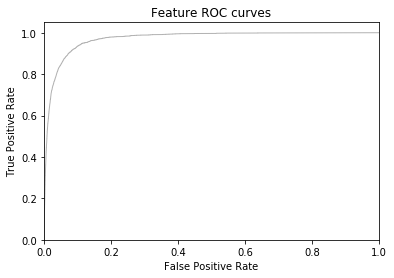

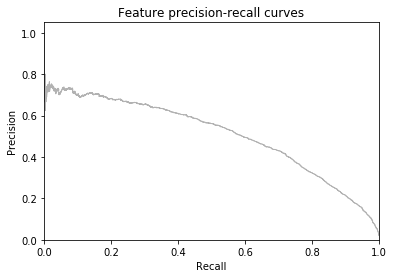

In [3]:
parse_configs_and_run(configs, lr=0.01)

## Help section (FAQs)

#### How to select `n_steps` (how online sampling works)

If you are using the `IntervalsSampler` (like we do in this example), you have passed in a list of regions from which you'd like to sample. If you are using `RandomPositionsSampler`, you are using the entire genome (minus any blacklist regions, see documentation [here](http://selene.flatironinstitute.org/sequences.html#genome)) for sampling. 

An `OnlineSampler` will randomly select a position from the regions you'd like to sample and query the reference sequence for a sequence of `sequence_length` bp centered at that position. 

When selecting `n_steps`, you should consider the number of possible positions from which the online sampler can sample, and how many times you might want to re-sample from that set. 

#### How to select: `report_stats_every_n_steps`, `n_validation_samples`, and `n_test_samples`

We currently report ROC AUC and average precision averaged across all classes (e.g. genomic features) predicted by the model for both the validation and the test sets.

`report_stats_every_n_steps` may be renamed in the future--when working with an online sampler, it can be used to report the validation ROC AUC and average precision after every estimated "epoch". You can set it to report more frequently than this if you'd like. 

Both `n_validation_samples` and `n_test_samples` should be larger enough such that we expect to sample positive examples for each feature. In the tutorial example here, we have set `sample_negative` to `True` because our model is only classifying whether a sequence contains 1 genomic feature or not. In a multi-class example, we may not need to do this because a positive example for 1 class might be a negative example for all other classes. In any case, you should estimate the number of samples you might randomly sample from regions in the genome to get to at least 1 positive example. **Otherwise, `roc_auc` and `average_precision` will always be reported as `None`** because all your samples will be labeled with 0 classes/genomic features.

Selene's `TrainModel` class by default sets `report_gt_feature_n_positives` to 10. This means you must have at least 10 positive examples for a genomic feature for the ROC AUC and average precision to be computed. 
